In [1]:
import awkward as ak
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import glob
import os
import json
import sys
import mplhep as hep
# hep.style.use(hep.style.ROOT) # For now ROOT defaults to CMS
hep.style.use(hep.style.ATLAS)

Quick function to load data from jsons into dict-like objects

In [2]:
def load_data(file_path):
    return ak.from_json(pathlib.Path(file_path))

Load all the data (this should take <1 min)

In [ ]:
# No BIB data
v2_path = glob.glob('**/*v2_noBIB_merged.json', recursive=True)[0] # find the v2_noBIB_merged.json file
v2_noBIB_merged = load_data(v2_path)

pt_all_path = glob.glob('**/*v0_noBIB_all.json', recursive=True)[0] # find the v0_noBIB_all.json file
pt_all = load_data(pt_all_path)

pt_all_5TeV_path = glob.glob('**/*v0_noBIB_all_5TeV.json', recursive=True)[0] # find the v0_noBIB_all_5TeV.json file
pt_all_5TeV = load_data(pt_all_5TeV_path)

# BIB data
bib_all_path = glob.glob('**/*v0_BIB_all.json', recursive=True)[0] # find the v0_BIB_all.json file
bib_all = load_data(bib_all_path)

bib_0_50_path = glob.glob('**/*v0_BIB_0_50.json', recursive=True)[0] # find the v0_BIB_0_50.json file
bib_0_50 = load_data(bib_0_50_path)

bib_50_250_path = glob.glob('**/*v0_BIB_50_250.json', recursive=True)[0] # find the v0_BIB_50_250.json file
bib_50_250 = load_data(bib_50_250_path)

bib_250_1000_path = glob.glob('**/*v0_BIB_250_1000.json', recursive=True)[0] # find the v0_BIB_250_1000.json file
bib_250_1000 = load_data(bib_250_1000_path)

bib_5TeV_path = glob.glob('**/*v0_BIB_5TeV.json', recursive=True)[0] # find the v0_BIB_5TeV.json file
bib_5TeV = load_data(bib_5TeV_path)

# Distributions Plotting

In [3]:
# Histogram plotting function that is intended to compare fake and truth-matched data
def plot_histogram(data, fake_key, truth_key, bins, x_label, y_label, x_range=None, y_scale='linear', file_name=None, custom_data_func=None):
    
    # Set up plotting parameters
    plt.style.use('seaborn-v0_8-colorblind')
    fontsize = 20
    plt.rcParams['font.size'] = fontsize

    plt.figure(figsize=(8, 6))
    
    if custom_data_func:
        fake_data, truth_data = custom_data_func(data)
    # Data in these jsons is stored as jagged arrays varying per event per track etc. so we need to flatten them
    else:
        fake_data = ak.flatten(data[fake_key])
        truth_data = ak.flatten(data[truth_key])

    # Bins input can either be a single itn or can be used as a np.linspace array
    if isinstance(bins, int):
        bins = (bins, bins)
    elif isinstance(bins, np.ndarray):
        bins = (bins, bins)

    # Create the histograms
    plt.hist(fake_data, bins=bins[0], linewidth=1.5, histtype='step', density=True, color='red', label='Fake')
    plt.hist(truth_data, bins=bins[1], linewidth=1.5, histtype='step', density=True, color='blue', label='Truth-Matched')
    
    if x_range:
        plt.xlim(x_range)
        
    plt.xlabel(x_label, loc='right')
    plt.ylabel(y_label, loc='top')
    plt.yscale(y_scale)
    plt.title(r'$\it{MAIA}$ Detector Concept', fontsize=fontsize, loc='right')
    
    # Get current y-axis limits and add 10% padding to the top
    y_min, y_max = plt.gca().get_ylim()
    plt.ylim(y_min, y_max * 1.1)
    
    # Custom Muon Collider text
    plt.text(0.04, 0.9, "Muon Collider", fontweight='bold', style='italic', transform=plt.gca().transAxes)
    plt.text(0.04, 0.83, "Simulation", transform=plt.gca().transAxes)
    
    # Or use mplhep to add the text
    # hep.atlas.text("Muon Collider")

    plt.legend(frameon=False, loc = 'upper right', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()
    
    if file_name:
        plt.savefig(file_name)
    plt.show()

# Function to choose which histogram to plot based on the plot_type argument
def choose_hist(data, plot_type):
    
    if plot_type == 'pt':
        plot_histogram(data, 'fake_pt', 'mcp_mu_pt', np.linspace(0, 1000, 50), 'Track $p_T$ [GeV]', 'Normalized Count', x_range=(0, 1000), y_scale='log')

    elif plot_type == 'phi':
        plot_histogram(data, 'fake_phi', 'mcp_mu_phi', (100), r'Track $\phi$', 'Normalized Count', x_range=(-np.pi, np.pi), y_scale='linear')

    elif plot_type == 'eta':
        plot_histogram(data, 'fake_eta', 'mcp_mu_eta', (100), r'Track $\eta$', 'Normalized Count', y_scale='linear')

    elif plot_type == 'chi2_ndf':
        plot_histogram(data, 'fake_chi2', 'LC_chi2', (100), r'Track $\chi^2/ndf$', 'Normalized Count', x_range=(0, 3), y_scale='linear', custom_data_func=lambda d: (ak.flatten(d['fake_chi2']) / ak.flatten(d['fake_ndf']), ak.flatten(d['LC_chi2']) / ak.flatten(d['LC_ndf'])))

    elif plot_type == 'd0':
        plot_histogram(data, 'fake_d0', 'LC_d0', (100,np.linspace(-0.2, 0.2, 100)), r'Track $d_0$ [mm]', 'Normalized Count', y_scale='log')

    elif plot_type == 'nhits':
        plot_histogram(data, 'fake_nhits', 'LC_nhits', np.arange(-0.5, 26, 1), 'Track Nhits', 'Normalized Count', y_scale='linear', custom_data_func=lambda d: (ak.flatten(d['fake_nhits']), ak.flatten(d['LC_nhits'])))

# if __name__ == "__main__":
#     if len(sys.argv) != 3:
#         print("Usage: python script.py <path_to_json_file> <plot_type>")
#         print("plot_type options: pt, phi, eta, chi2_ndf, d0, nhits")
#         sys.exit(1)
#     json_file_path = sys.argv[1]
#     plot_type = sys.argv[2]
#     choose_hist(json_file_path, plot_type)

plot_type options: pt, phi, eta, chi2_ndf, d0, nhits

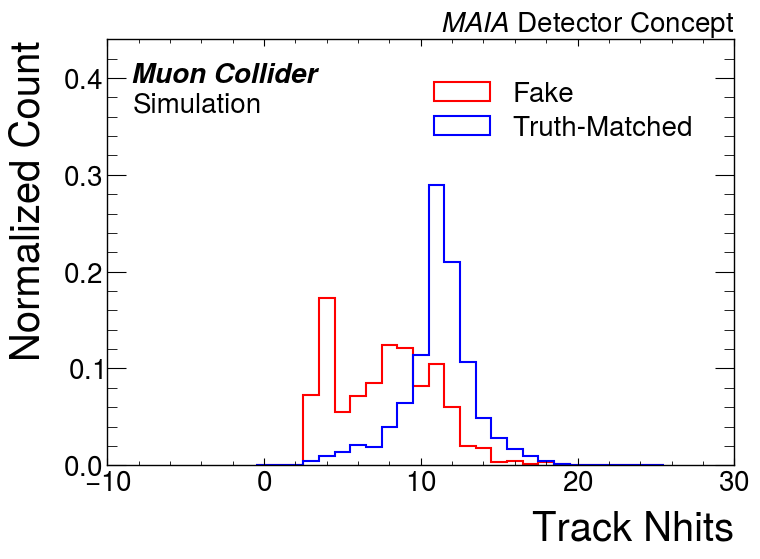

In [4]:
# print((data))
choose_hist(v2_noBIB_merged, 'nhits')

# Efficiencies Plotting

In [5]:
# Efficiencies calculated using fraction of truth-matched tracks/truth tracks in each bin
def calculate_efficiencies(track_data_list, truth_data_list, num_bins=10, min_value=None, max_value=None):
    
    # Can assign min and max values to the data, don't have to
    if min_value is None:
        min_value = np.min([np.min(np.ravel(truth_data)) for truth_data in truth_data_list])

    if max_value is None:
        max_value = np.max([np.max(np.ravel(truth_data)) for truth_data in truth_data_list])

    # Bins based on min and max values
    efficiency_bins = np.linspace(min_value, max_value, num_bins+1)
    
    results = []
    bin_width = efficiency_bins[1] - efficiency_bins[0]
    # Loop over the track and truth data 
    for track_data, truth_data in zip(track_data_list, truth_data_list):
        efficiencies = []
        errors = []
        bin_centers = []
        # For each bin, assing the min and max values and then calculate the efficiency
        for j in range(len(efficiency_bins) - 1):
            bin_min = efficiency_bins[j]
            bin_max = efficiency_bins[j + 1]
            track_data_in_bin = np.ravel(track_data)[(np.ravel(track_data) >= bin_min) & (np.ravel(track_data) < bin_max)]
            truth_data_in_bin = np.ravel(truth_data)[(np.ravel(truth_data) >= bin_min) & (np.ravel(truth_data) < bin_max)]
            if len(track_data_in_bin) != 0:
                efficiency = len(track_data_in_bin) / len(truth_data_in_bin)
                error = efficiency * np.sqrt((1 - efficiency) / len(track_data_in_bin))
            # If bin is empty, efficiency is 0
            else:
                efficiency = 0
                error = 0
            efficiencies.append(efficiency)
            errors.append(error)
            bin_centers.append((bin_min + bin_max) / 2)
        results.append((bin_centers, efficiencies, errors, bin_width))
    
    return results, min_value, max_value


In [6]:
def plot_efficiencies(results, min_value, max_value, xlabel=None, ylim=None, bib=False, labels="", savepdf=False, savename=''):
    plt.figure(figsize=(8, 6))

    # Assign plotting parameters
    alpha = 1.0
    size = 10

    # When plotting multiple datasets, loop through label names, decrease the size and alpha of the markers
    for i, (bin_centers, efficiencies, errors, bin_width) in enumerate(results):
        label = labels[i] if labels else f"Dataset {i+1}"
        if bib:
            label += ' w/ BIB'
        plt.errorbar(bin_centers, efficiencies, yerr=errors, xerr=bin_width/2, fmt='o', label=label, markersize=size, alpha=alpha)
        size -= 2
        alpha -= 0.2

    # Set x and y limits (with some leeway)
    plt.xlim(min_value-10, max_value+10)
    if ylim is None:
        plt.ylim(0, 1.1)
    else:
        plt.ylim(ylim)
        
    if xlabel is not None:
        plt.xlabel(xlabel, loc='right', fontsize=25)
    plt.ylabel('Reconstruction Efficiency', loc='top', fontsize=25)
    plt.title(r'$\it{MAIA}$ Detector Concept', fontsize=20, loc = 'right')
    
    # Custom Muon Collider text
    # plt.text(0.04, 0.9, "Muon Collider", fontweight='bold', style='italic', transform=plt.gca().transAxes)
    # plt.text(0.04, 0.83, "Simulation", transform=plt.gca().transAxes)
    
    # Or use mplhep to add the text
    hep.atlas.text("Muon Collider")
    
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(loc='lower left', fontsize=20)

    plt.show()

Convert theta to degrees

In [7]:
# Convert theta to degrees
bib_track_theta = np.degrees(bib_all['LC_track_theta'])
bib_truth_theta = np.degrees(2 * np.arctan(np.exp(-bib_all['mcp_mu_eta'])))
LC_track_theta = np.degrees(pt_all['LC_track_theta'])
mcp_mu_theta = np.degrees(2 * np.arctan(np.exp(-pt_all['mcp_mu_eta'])))

### No BIB

Cell to clean (make cuts) and separate data into Barrel/Endcap

In [8]:
which_data = v2_noBIB_merged

# Assign variables to no-BIB data
LC_pt_match = which_data['LC_pt_match']
mcp_mu_pt = which_data['mcp_mu_pt']
LC_nhits = which_data['LC_nhits']
LC_track_theta = np.degrees(which_data['LC_track_theta'])
mcp_mu_theta = np.degrees(2 * np.arctan(np.exp(-which_data['mcp_mu_eta'])))

# Clean track using pT >=1 GeV, d0 <= 0.1 mm, and nhits > 4
track_clean = (ak.flatten(which_data['LC_track_pt'])>=1) & (ak.flatten(which_data['LC_d0'])<= 0.1) & (ak.flatten(which_data['LC_nhits'])>4)

# Define the eta transition region from barrel to endcap
transition_region = 1

# Separate the data into barrel and endcap
track_barrel = (np.abs(ak.flatten(which_data['LC_eta_match']))<transition_region)
truth_barrel = (np.abs(ak.flatten(which_data['mcp_mu_eta']))<transition_region)
track_endcap = (np.abs(ak.flatten(which_data['LC_eta_match']))>=transition_region)
truth_endcap = (np.abs(ak.flatten(which_data['mcp_mu_eta']))>=transition_region)

# Sanity check with some overall efficiencies
# print(len((LC_pt_match[track_barrel])), len((LC_pt_match[track_endcap])), len(LC_pt_match), len(mcp_mu_pt[truth_barrel]), len((mcp_mu_pt[truth_endcap])), len(mcp_mu_pt))
print("For no BIB:")
print("Overall efficiency:", len((LC_pt_match))/len((mcp_mu_pt)))
print("Barrel Efficiency:", len((LC_pt_match[track_barrel]))/len((mcp_mu_pt[truth_barrel])))
print("Endcap Efficiency:", len((LC_pt_match[track_endcap]))/len((mcp_mu_pt[truth_endcap])))
print("Lost Efficiency after cleaning:", len((LC_pt_match))/len((mcp_mu_pt)) - len((LC_pt_match)[track_clean])/len((mcp_mu_pt)))

For no BIB:
Overall efficiency: 0.9574958392011266
Barrel Efficiency: 0.994948968964799
Endcap Efficiency: 0.8977574750830565
Lost Efficiency after cleaning: 0.016419152477275545


Binned in Theta, comparing before and after cleaning

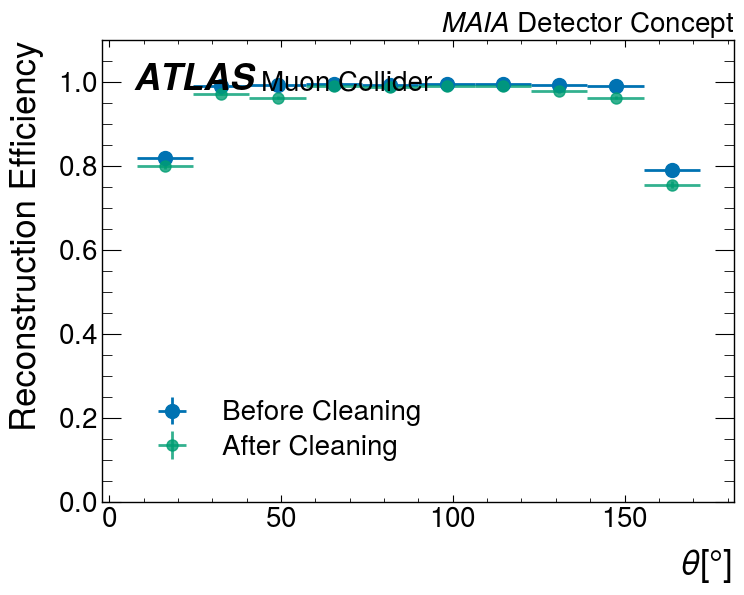

In [9]:
results, min_value, max_value = calculate_efficiencies([LC_track_theta,LC_track_theta[track_clean]], [mcp_mu_theta,mcp_mu_theta]) 
plot_efficiencies(results, min_value, max_value, xlabel=r"$\theta [\degree]$ ", labels=["Before Cleaning", "After Cleaning"])

Binned in pT

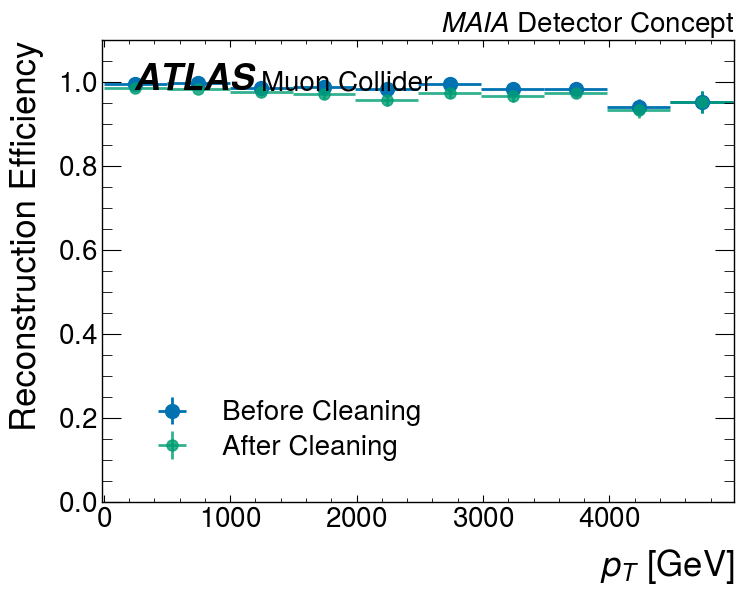

In [10]:
results, min_value, max_value = calculate_efficiencies([LC_pt_match[track_barrel],LC_pt_match[track_clean & track_barrel]], [mcp_mu_pt [truth_barrel],mcp_mu_pt[truth_barrel]])
plot_efficiencies(results, min_value, max_value, xlabel="$p_T$ [GeV]", labels=["Before Cleaning", "After Cleaning"])

### BIB

In [11]:
# Assign variables to BIB data
bib_track_pt = bib_all['LC_pt_match']
bib_truth_pt = bib_all['mcp_mu_pt']
bib_nhits = bib_all['LC_nhits']
bib_track_eta = bib_all['LC_eta_match']
bib_truth_eta = bib_all['mcp_mu_eta']

# Clean track using pT >=1 GeV, d0 <= 0.1 mm, and nhits > 4
bib_track_clean = (ak.flatten(bib_track_pt)>=1) & (ak.flatten(bib_all['LC_d0'])<= 0.1) & (ak.flatten(bib_nhits)>4)

# Define the eta transition region from barrel to endcap
transition_region = 1

# Separate the data into barrel and endcap
bib_track_barrel = (np.abs(ak.flatten(bib_track_eta))<transition_region)
bib_truth_barrel = (np.abs(ak.flatten(bib_truth_eta))<transition_region)
bib_track_endcap = (np.abs(ak.flatten(bib_track_eta))>=transition_region)
bib_truth_endcap = (np.abs(ak.flatten(bib_truth_eta))>=transition_region)

# Sanity check with some overall efficiencies
# print(len((LC_pt_match[track_barrel])), len((LC_pt_match[track_endcap])), len(LC_pt_match), len(mcp_mu_pt[truth_barrel]), len((mcp_mu_pt[truth_endcap])), len(mcp_mu_pt))
print("For BIB:")
print("Total efficiency:", len((bib_track_pt))/len((bib_truth_pt)))
print("Barrel efficiency:", len((bib_track_pt[bib_track_barrel]))/len((bib_truth_pt[bib_truth_barrel])))
print("Endcap efficiency:", len((bib_track_pt[bib_track_endcap]))/len((bib_truth_pt[bib_truth_endcap])))
print("Efficiency lost from cleaning:", len((bib_track_pt))/len((bib_truth_pt)) - len((bib_track_pt)[bib_track_clean])/len((bib_truth_pt)))

For BIB:
Total efficiency: 0.8609607577807848
Barrel efficiency: 0.9634831460674157
Endcap efficiency: 0.70578231292517
Efficiency lost from cleaning: 0.06123139377537212


Binned in Theta

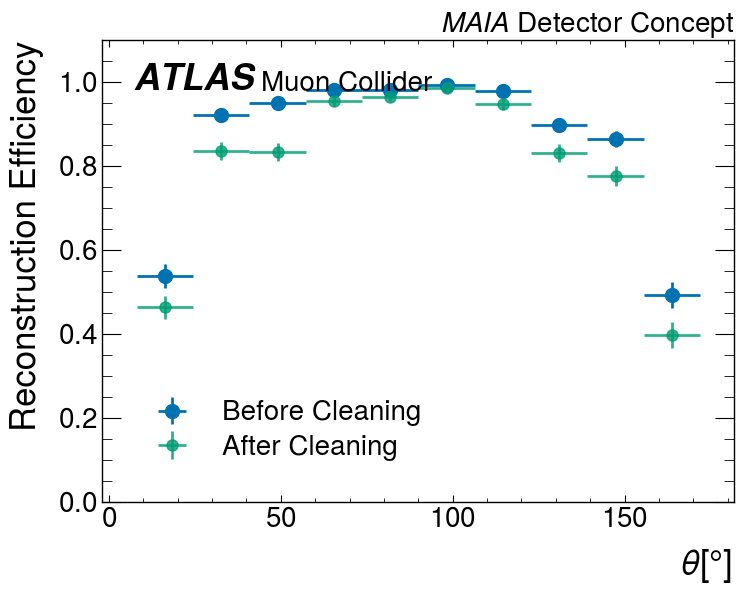

In [12]:
results, min_value, max_value = calculate_efficiencies([bib_track_theta,bib_track_theta[bib_track_clean]], [bib_truth_theta,bib_truth_theta])
plot_efficiencies(results, min_value, max_value, xlabel=r"$\theta [\degree]$ ", labels=["Before Cleaning", "After Cleaning"])

Binned in pT

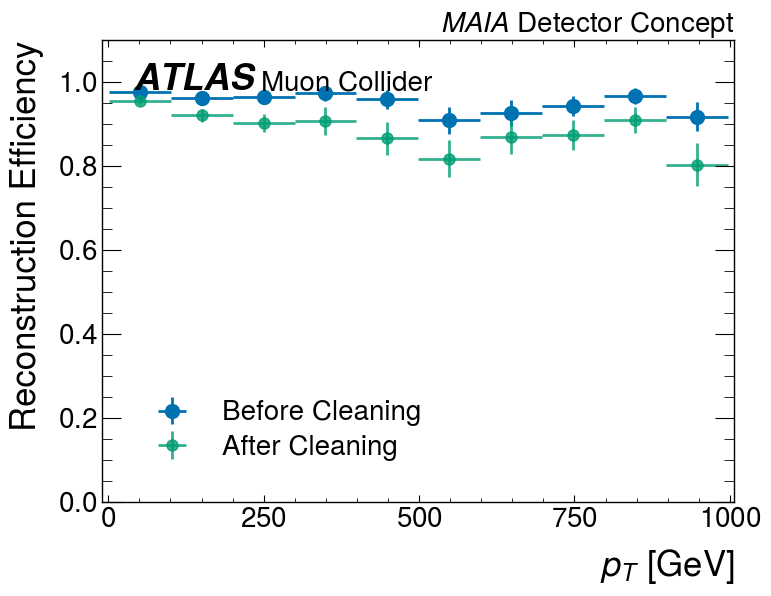

In [13]:
results, min_value, max_value = calculate_efficiencies([bib_track_pt[bib_track_barrel],bib_track_pt[bib_track_clean & bib_track_barrel]], [bib_truth_pt [bib_truth_barrel],bib_truth_pt[bib_truth_barrel]])
plot_efficiencies(results, min_value, max_value, xlabel="$p_T$ [GeV]", labels=["Before Cleaning", "After Cleaning"])

# Resolutions Plotting

### Setup before plotting

Assign the data to variables

In [14]:
which_data = v2_noBIB_merged

LC_nhits = which_data['LC_nhits']
LC_pixel_nhits = which_data['LC_pixel_nhits']
LC_d0 = which_data['LC_d0']
LC_z0 = which_data['LC_z0']
LC_track_pt = which_data['LC_track_pt']
LC_track_theta = np.degrees(which_data['LC_track_theta'])
LC_track_eta = which_data['LC_track_eta']
LC_pt_res = which_data['LC_pt_res']
LC_pt_match = which_data['LC_pt_match']
LC_eta_match = which_data['LC_eta_match']
LC_theta_match = np.degrees(2 * np.arctan(np.exp(-LC_eta_match)))
LC_phi_match = which_data['LC_phi_match']
LC_ndf = which_data['LC_ndf']
LC_chi2 = which_data['LC_chi2']
LC_dr = which_data['LC_dr']

bib_0_50_theta = np.degrees(2*np.arctan(np.exp(-bib_0_50['LC_eta_match'])))
bib_50_250_theta = np.degrees(2*np.arctan(np.exp(-bib_50_250['LC_eta_match'])))
bib_250_1000_theta = np.degrees(2*np.arctan(np.exp(-bib_250_1000['LC_eta_match'])))

Functions to calculate and plot resolutions

In [15]:
# Function for creating a Gaussian fit
def gaussian(x, a, mu, sigma):
    return a * np.exp(-0.5 * ((x - mu) / sigma)**2)

def double_gaussian(x, a1, mu1, rms1, a2, mu2, rms2):
    gauss1 = a1 * np.exp(-((x - mu1) ** 2) / (2 * rms1 ** 2))
    gauss2 = a2 * np.exp(-((x - mu2) ** 2) / (2 * rms2 ** 2))
    return gauss1 + gauss2

# Function for fitting a Gaussian to the data
def fit_gaussian(slice_data, bins, mean = 0, rms = 0.01):
    """
    Fit a Gaussian to the input data slice.

    Parameters:
        slice_data (numpy.ndarray): Input data slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is np.linspace(-1, 1, 300).
        mean (float, optional): Mean value for the Gaussian fit. Default is 0.
        rms (float, optional): RMS value for the Gaussian fit. Default is 0.01.

    Returns:
        tuple: Tuple containing fit parameters (popt), covariance matrix (pcov), and bin centers.
    """
    if mean is None:
        mean = np.mean(slice_data)
    if rms is None:
        rms = np.sqrt(np.mean(np.square(slice_data - mean)))
    if bins is None:
        bins = np.linspace(np.min(slice_data), np.max(slice_data), int(np.sqrt(len(slice_data))))
    counts, bin_edges = np.histogram(slice_data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[max(counts), mean, rms])
    return popt, pcov, bin_centers

def fit_double_gaussian(slice_data, bins=np.linspace(-0.001, 0.001, 300), mean1=0, rms1=0.0001, mean2=0, rms2=0.0005):
    """
    Fit a double Gaussian to the input data slice.
    
    Parameters:
        slice_data (numpy.ndarray): Input data slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is np.linspace(-1, 1, 300).
        mean1 (float, optional): Mean value for the first Gaussian. Default is 0.
        rms1 (float, optional): RMS value for the first Gaussian. 
        mean2 (float, optional): Mean value for the second Gaussian. Default is 0.
        rms2 (float, optional): RMS value for the second Gaussian. 
        
    Returns:
        tuple: Tuple containing fit parameters (popt), covariance matrix (pcov), and bin centers.
    """
    if bins is None:
        bins = np.linspace(-2.5*np.sqrt(np.mean(np.square(slice_data))), -2.5*np.sqrt(np.mean(np.square(slice_data))), int(np.sqrt(len(slice_data))))
    counts, bin_edges = np.histogram(slice_data, bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    p0 = [max(counts), mean1, rms1, max(counts) / 2, mean2, rms2]
    popt, pcov = curve_fit(double_gaussian, bin_centers, counts, p0=p0)
    return popt, pcov, bin_centers

# Function to calculate the mean and RMS of a double Gaussian distribution
def calculate_mean_and_rms(popt, pcov):
    """
    Calculate a representative mean and RMS for a double Gaussian distribution.
    
    Parameters:
        popt (list or numpy.ndarray): Optimal parameters from the double Gaussian fit.
        Expected order: amp1, mean1, rms1, amp2, mean2, rms2. 
    Returns:
        tuple: A tuple containing the representative mean and RMS.
    """
    amp1, mean1, rms1, amp2, mean2, rms2 = popt
    total_amp = amp1 + amp2
    
    # Calculate weighted mean
    mean = (amp1 * mean1 + amp2 * mean2) / total_amp
    
    # Calculate weighted variance
    variance1 = rms1 ** 2
    variance2 = rms2 ** 2
    mean_variance = ((amp1 * (mean1 - mean) ** 2 + amp2 * (mean2 - mean) ** 2) / total_amp)
    weighted_variance = (amp1 * variance1 + amp2 * variance2) / total_amp + mean_variance
    rms1_uncertainty = np.sqrt(pcov[2, 2])  # Uncertainty of rms1
    rms2_uncertainty = np.sqrt(pcov[5, 5])  # Uncertainty of rms2

    # And assuming w1 and w2 are your weights for rms1 and rms2:
    # For example, let's use the amplitudes as weights
    w1 = amp1 / (amp1 + amp2)
    w2 = amp2 / (amp1 + amp2)

    # Then, a simplified weighted uncertainty for the RMS might be calculated as:
    weighted_rms_uncertainty = np.sqrt((w1**2 * rms1_uncertainty**2) + (w2**2 * rms2_uncertainty**2))    
    # Calculate representative RMS
    rms = np.sqrt(weighted_variance)
    sem = np.sqrt(weighted_rms_uncertainty)
    
    return mean, rms, sem

# Function to process data and calculate RMS values
def process_data(datax, datay, numbins, bins=None):
    """
    Process data to calculate RMS values binned by the provided data.

    Parameters:
        datax (list of numpy.ndarray): List of x-data arrays (Usually theta values).
        datay (list of numpy.ndarray): List of y-data arrays (Either pT or d0 resolution).
        numbins (int): How many bins in theta.
        bins (list of numpy.ndarray, optional): List of binning arrays for histograms.

    Returns:
        list: A list of dictionaries containing processed results for each dataset.
              Each dictionary contains bin centers, rms values, and sem values.
    """
    processed_results = []

    if isinstance(bins, np.ndarray):
        bins = [bins] * len(datay)  # Replicate the array for each dataset

    # Loop over the data 
    for j in range(len(datay)):
        # Take flattened and transposed data
        data_flatx = np.array(np.ravel(datax[j])).T
        data_flaty = np.array(np.ravel(datay[j])).T
        x_bins = np.linspace(data_flatx.min(), data_flatx.max(), numbins + 1)
        rms_values = []
        sem_values = []
        bin_centers = []

        # Loop over the theta bins
        for i in range(numbins):
            # Slice the data based on the theta bins
            slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
            try:
                # Fit a Gaussian to the slice data using the fit_gaussian function
                popt, pcov, _ = fit_gaussian(slice_data, bins=bins[j])
                fitted_rms = popt[2]
                sem = (np.sqrt(np.diag(pcov)))[2]
            except:
                try:
                    popt, pcov, _ = fit_double_gaussian(slice_data, bins=bins[j])
                    _, fitted_rms, sem = calculate_mean_and_rms(popt, pcov)
                    if sem == np.inf:
                        sem = np.std(slice_data, ddof=1) / np.sqrt(2 * (len(slice_data) - 1))
                except:
                    fitted_rms = np.sqrt(np.mean(np.square(slice_data - np.mean(slice_data))))
                    sem = np.std(slice_data, ddof=1) / np.sqrt(2 * (len(slice_data) - 1))

            rms_values.append(np.abs(fitted_rms))
            sem_values.append(sem)
            bin_centers.append((x_bins[i] + x_bins[i + 1]) / 2)

        processed_results.append({
            'bin_centers': np.array(bin_centers),
            'rms_values': np.array(rms_values),
            'sem_values': np.array(sem_values),
            'x_err': (data_flatx.max() - data_flatx.min()) / (2 * numbins)
        })

    return processed_results

# Function to fold the data over Theta = 90 because detector is symmetric in Theta in the case of low statistics (high pT and BIB data)
def fold_data(data, bib = True):
    # Filter out data points less than 90
    if bib == False:
        right_side_data = (data[(ak.flatten((LC_theta_match)[(LC_pt_match)>1000])) > 90])
        left_side_data = (data[(ak.flatten((LC_theta_match)[(LC_pt_match)>1000])) <= 90])
    else:
        right_side_data = (data[(ak.flatten((bib_5TeV['LC_track_theta']) > np.pi/2))])
        left_side_data = (data[(ak.flatten((bib_5TeV['LC_track_theta']) <= np.pi/2))])
    if np.array_equal(data, ak.flatten(bib_5TeV['LC_track_theta'][ak.flatten(bib_5TeV['LC_pt_match']>1000)])):
        # Mirror the data onto the left side
        mirrored_data_right = np.pi - (right_side_data)
        mirrored_data_left = np.pi - (left_side_data)
        mirrored_data = np.concatenate((mirrored_data_right, mirrored_data_left))
        folded_data = np.concatenate((data, mirrored_data_right))
    elif np.array_equal(data, ak.flatten(LC_theta_match[np.ravel(LC_pt_match)>1000])):
        mirrored_data_right = 180 - (right_side_data)
        mirrored_data_left = 180 - (left_side_data)
        mirrored_data = np.concatenate((mirrored_data_right, mirrored_data_left))
        folded_data = np.concatenate((data, mirrored_data_right))
    else:
        # Concatenate the mirrored data with the original data
        mirrored_data = np.concatenate((right_side_data, left_side_data))
        folded_data = np.concatenate((data, right_side_data))
    return (folded_data)


Plotting function

In [16]:
def plot_processed_data(processed_results, labels=None, xlabel='', ylabel='', title='', fontsize=25, log=False, ylim=None, xlim=None, savepdf=False, savename=''):
    """
    Plot the processed RMS data.

    Parameters:
        processed_results (list): List of dictionaries containing processed data.
        labels (list of str, optional): Labels for the data series.
        xlabel (str, optional): X-axis label.
        ylabel (str, optional): Y-axis label.
        title (str, optional): Plot title.
        fontsize (int, optional): Font size for the plot labels.
        log (bool, optional): Use a logarithmic y-axis scale.
        ylim (tuple, optional): Y-axis limits.
        xlim (tuple, optional): X-axis limits.
        savepdf (bool, optional): Save the plot as a PDF file.
        savename (str, optional): Name of the saved PDF file.
    """
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Loop over the processed results (dictionary of bin centers, rms values, sem values, and theta width) and create errorbar graphs
    for i, result in enumerate(processed_results):
        label = labels[i] if labels else ''
        ax.errorbar(
            result['bin_centers'], 
            result['rms_values'], 
            xerr=result['x_err'], 
            yerr=result['sem_values'], 
            fmt='o', 
            markersize=6, 
            label=label
        )
    if len(title) > 0:
        ax.set_title(title, fontsize=fontsize)
    else:
        ax.set_title(r'$\it{MAIA}$ Detector Concept', fontsize=fontsize, loc = 'right')
        
    ax.set_xlabel(xlabel, loc='right', fontsize=fontsize)
    ax.set_ylabel(ylabel, loc='top', fontsize=fontsize)
    if log:
        ax.set_yscale('log')
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    if labels:
        ax.legend(fontsize=15)
    ax.tick_params(labelsize=20)

    if savepdf:
        plt.savefig(savename, format='pdf', bbox_inches='tight')

    plt.show()


### No BIB

Cell for making cuts and assigning binning/xy limits

In [17]:
# Split the data into 4 pT ranges (and fold the data for the high pT range)
theta_all = [LC_theta_match[np.ravel(LC_pt_match)<=50], LC_theta_match[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_theta_match[np.ravel(LC_pt_match)>250 & (np.ravel(LC_pt_match)<=1000)], fold_data(ak.flatten(LC_theta_match[np.ravel(LC_pt_match)>1000]), bib = False)]
d0_all = [LC_d0[np.ravel(LC_pt_match)<=50], LC_d0[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_d0[np.ravel(LC_pt_match)>250 & (np.ravel(LC_pt_match)<=1000)], fold_data(ak.flatten(LC_d0[np.ravel(LC_pt_match)>1000]), bib = False)]
pt_res_all = [LC_pt_res[np.ravel(LC_pt_match)<=50], LC_pt_res[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_pt_res[np.ravel(LC_pt_match)>250 & (np.ravel(LC_pt_match)<=1000)], fold_data(ak.flatten(LC_pt_res[np.ravel(LC_pt_match)>1000]), bib = False)]
pt_track_all = [LC_track_pt[np.ravel(LC_pt_match)<=50], LC_track_pt[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_track_pt[np.ravel(LC_pt_match)>250 & (np.ravel(LC_pt_match)<=1000)], fold_data(ak.flatten(LC_track_pt[np.ravel(LC_pt_match)>1000]), bib = False)]
pt_match_all =  [LC_pt_match[np.ravel(LC_pt_match)<=50], LC_pt_match[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_pt_match[np.ravel(LC_pt_match)>250 & (np.ravel(LC_pt_match)<=1000)], fold_data(ak.flatten(LC_pt_match[np.ravel(LC_pt_match)>1000]), bib = False)]
nhits_all =  [LC_nhits[np.ravel(LC_pt_match)<=50], LC_nhits[(np.ravel(LC_pt_match)>50) & (np.ravel(LC_pt_match)<=250)], LC_nhits[np.ravel(LC_pt_match)>250 & (np.ravel(LC_pt_match)<=1000)], fold_data(ak.flatten(LC_nhits[np.ravel(LC_pt_match)>1000]), bib = False)]

# Assign cuts
theta_all_masked = []
d0_all_masked = []
pt_res_all_masked = []
pt_match_all_masked = []
for i in range(len(theta_all)):
    x = theta_all[i]
    y = d0_all[i]
    w = pt_match_all[i]
    z = pt_res_all[i] /w # can remove /w for just (truth-reco)/(truth pT) instead of /pT^2
    v = pt_track_all[i]
    u = nhits_all[i]
    # Create a boolean mask for the condition
    theta_cut = (0 <= x) & (x < 180)
    pt_res_cut = np.abs(z) > 0
    pt_cut = v > 1
    d0_cut = y <= 0.1
    nhits_cut = u > 4
    # Apply the mask to filter the arrays
    mask = theta_cut & pt_res_cut & pt_cut & d0_cut & nhits_cut
    x_masked = x[mask]
    y_masked = y[mask]
    z_masked = z[mask]
    w_masked = w[mask]
    theta_all_masked.append(x_masked)
    d0_all_masked.append(y_masked)
    pt_res_all_masked.append(z_masked)
    pt_match_all_masked.append(w_masked)
# theta_all = ak.concatenate([theta_0_50, theta_50_250, theta_match],axis = 0)
numpoints = 6
array1 = np.linspace(-0.5,0.5,300)    # pt_0_50_bins
array2 = np.linspace(-0.5,0.5,300)  # pt_50_250_bins
array3 = np.linspace(-0.5,0.5,300) # pt_250_1000_bins
array4 = np.linspace(-0.005, 0.005, 250)  # pt_1000_5000_bins
pt_2_bins = [array1, array2, array3, array4] # pt_2 meaning /pt^2
d0_ylim = (0,0.0065)
pt_ylim = (0,0.0015)

d0 res vs Theta

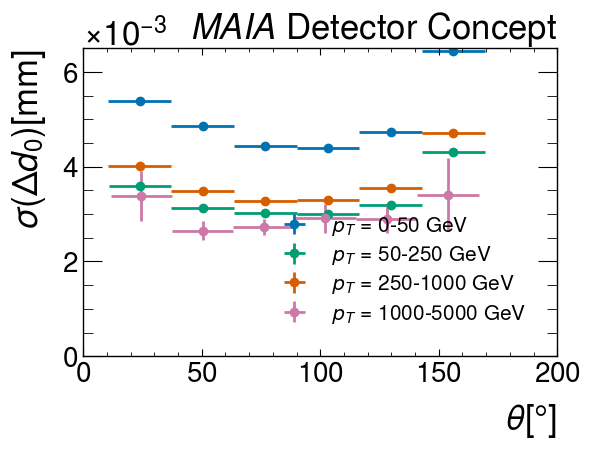

In [18]:
processed_data = process_data(
    datax=theta_all_masked,
    datay=d0_all_masked,
    numbins=numpoints,
    bins=pt_2_bins
)
plot_processed_data(
    processed_results=processed_data,
    labels=[r'$p_T$ = 0-50 GeV', r'$p_T$ = 50-250 GeV', r'$p_T$ = 250-1000 GeV', r'$p_T$ = 1000-5000 GeV'],
    xlabel=r'$\theta[\degree]$',
    ylabel=r'$\sigma(\Delta d_0)$[mm]',
    # title=r'Single $\mu^{\pm}$ no BIB @ 10TeV',
    ylim=d0_ylim,
)


pt res vs Theta

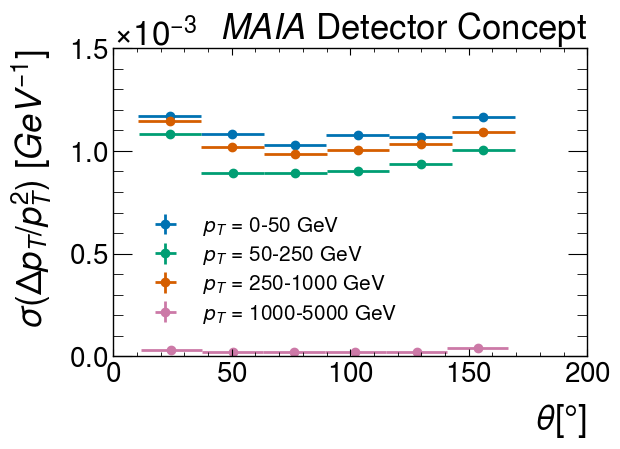

In [19]:
processed_data = process_data(
    datax=theta_all_masked,
    datay=pt_res_all_masked,
    numbins=numpoints,
    bins=pt_2_bins
)
plot_processed_data(
    processed_results=processed_data,
    labels=[r'$p_T$ = 0-50 GeV', r'$p_T$ = 50-250 GeV', r'$p_T$ = 250-1000 GeV', r'$p_T$ = 1000-5000 GeV'],
    xlabel=r'$\theta[\degree]$',
    ylabel= r'$\sigma(\Delta p_T/p_T^2)$ $[GeV^{-1}]$',
    # title=r'Single $\mu^{\pm}$ no BIB @ 10TeV',
    ylim=pt_ylim,
)


### BIB

In [20]:
bib_theta_all = [bib_0_50_theta, bib_50_250_theta, bib_250_1000_theta,  np.degrees(fold_data(ak.flatten((bib_5TeV['LC_track_theta'][ak.flatten(bib_5TeV['LC_pt_match']>1000)]))))]
bib_d0_all = [bib_0_50['LC_d0'], bib_50_250['LC_d0'], bib_250_1000['LC_d0'],  fold_data(ak.flatten(bib_5TeV['LC_d0'][ak.flatten(bib_5TeV['LC_pt_match']>1000)]))]
bib_pt_res_all = [bib_0_50['LC_pt_res'], bib_50_250['LC_pt_res'], bib_250_1000['LC_pt_res'], fold_data(ak.flatten(bib_5TeV['LC_pt_res'][ak.flatten(bib_5TeV['LC_pt_match']>1000)]))]
bib_track_pt_all = [bib_0_50['LC_track_pt'], bib_50_250['LC_track_pt'], bib_250_1000['LC_track_pt'], fold_data(ak.flatten(bib_5TeV['LC_track_pt'][ak.flatten(bib_5TeV['LC_pt_match']>1000)]))]
bib_pt_match_all = [bib_0_50['LC_pt_match'], bib_50_250['LC_pt_match'], bib_250_1000['LC_pt_match'], fold_data(ak.flatten(bib_5TeV['LC_pt_match'][ak.flatten(bib_5TeV['LC_pt_match']>1000)]))]
bib_nhits_all = [bib_0_50['LC_nhits'], bib_50_250['LC_nhits'], bib_250_1000['LC_nhits'], fold_data(ak.flatten(bib_5TeV['LC_nhits'][ak.flatten(bib_5TeV['LC_pt_match']>1000)]))]

bib_theta_all_masked = []
bib_d0_all_masked = []
bib_pt_res_all_masked = []
bib_pt_match_all_masked = []
for i in range(len(bib_theta_all)):
    x = bib_theta_all[i]
    y = bib_d0_all[i]
    w = bib_pt_match_all[i]
    z = bib_pt_res_all[i] # add '/w' for pt^2
    v = bib_track_pt_all[i]
    u = bib_nhits_all[i]
    # Create a boolean mask for the condition
    theta_cut = (0 <= x) & (x < 180)
    pt_res_cut = np.abs(z) > 0
    pt_cut = v > 1
    d0_cut = y <= 0.1
    nhits_cut = u > 4
    # Apply the mask to filter the arrays
    mask = theta_cut & pt_res_cut & pt_cut & d0_cut & nhits_cut
    x_masked = x[mask]
    y_masked = y[mask]
    z_masked = z[mask]
    w_masked = w[mask]
    bib_theta_all_masked.append(x_masked)
    bib_d0_all_masked.append(y_masked)
    bib_pt_res_all_masked.append(z_masked)
    bib_pt_match_all_masked.append(w_masked)
# bib_theta_all = ak.concatenate([theta_0_50, theta_50_250, theta_match],axis = 0)
numpoints = 5
array1 = np.linspace(-0.01, 0.01, 200)    # pt_0_50_bins for gaussian fitting
array2 = np.linspace(-0.005, 0.005, 200)  # pt_50_250_bins " " "
array3 = np.linspace(-0.003, 0.003, 200) # pt_250_1000_bins " " "
array4 = np.linspace(-0.001, 0.001, 200)  # pt_1000_5000_bins " " "
pt_2_bins = [array1, array2, array3, array4] # use for /pt^2
pt_bins = [array1*10, array2*10, array3*10, array4*5] # use for /pt (also works well for d0)
d0_ylim = (0,0.01)
pt_ylim = (0,0.02) # better for /pt^2?

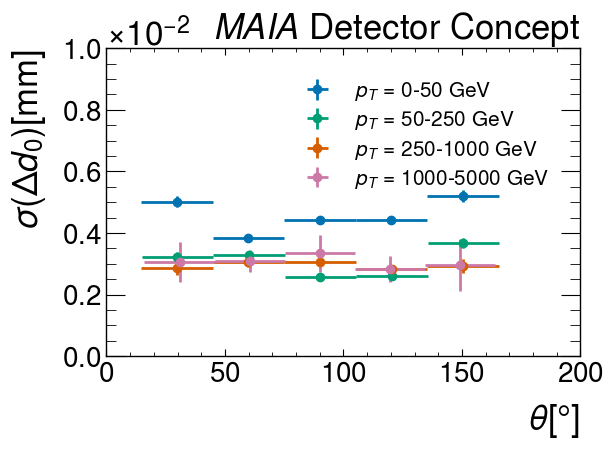

In [21]:
processed_data = process_data(
    datax=bib_theta_all_masked,
    datay=bib_d0_all_masked, 
    numbins=numpoints,
    bins=pt_bins
)
plot_processed_data(
    processed_results=processed_data,
    labels=[r'$p_T$ = 0-50 GeV', r'$p_T$ = 50-250 GeV', r'$p_T$ = 250-1000 GeV', r'$p_T$ = 1000-5000 GeV'],
    xlabel=r'$\theta[\degree]$',
    ylabel=r'$\sigma(\Delta d_0)$[mm]',
    # title=r'Single $\mu^{\pm}$ BIB @ 10TeV',
    ylim=d0_ylim,
)


C:\Users\leoro\AppData\Local\Temp\ipykernel_77244\3656881052.py:91: RuntimeWarning: invalid value encountered in sqrt
  rms = np.sqrt(weighted_variance)


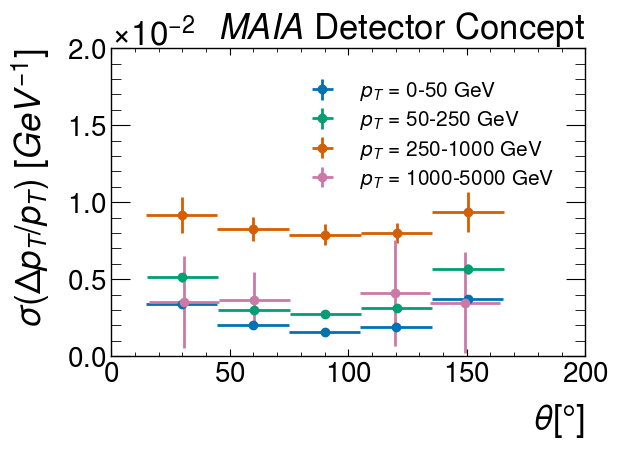

In [22]:
processed_data = process_data(
    datax=bib_theta_all_masked,
    datay=bib_pt_res_all_masked,
    numbins=numpoints,
    bins=pt_bins
)
plot_processed_data(
    processed_results=processed_data,
    labels=[r'$p_T$ = 0-50 GeV', r'$p_T$ = 50-250 GeV', r'$p_T$ = 250-1000 GeV', r'$p_T$ = 1000-5000 GeV'],
    xlabel=r'$\theta[\degree]$',
    ylabel=r'$\sigma(\Delta p_T/p_T)$ $[GeV^{-1}]$',
    # title=r'Single $\mu^{\pm}$ BIB @ 10TeV',
    ylim=pt_ylim,
)


# Extra

## Check Individual Gaussians

If some points have large error bars or are not fitting well, check the individual gaussians

In [23]:
def plotrms_slice(datax, datay, x_bins, bins=None, xlim = None, title="", rv = False, sigma5 = False):
    """
    Plot a 1D histogram and fit a Gaussian to it for a specified x-slice.

    Parameters:
        datax (numpy.ndarray): x-data array.
        datay (numpy.ndarray): y-data array.
        x_bins (numpy.ndarray): Binning for the x-slice.
        bins (numpy.ndarray, optional): Binning for histogram. Default is None.
        xlim (tuple, optional): X-axis limits. Default is None.
        title (str, optional): Plot title. Default is an empty string.
        rv (bool, optional): Return fitted RMS and mean. Default is False.
        sigma5 (bool, optional): Plot sigma-5 lines. Default is False.
    Returns:
        list: List containing fitted RMS and mean if rv=True and a Gaussian fit was successful; otherwise [0, 0].
    """
    data_flatx = np.array(np.ravel(datax)).T
    data_flaty = np.array(np.ravel(datay)).T
    for i in range(len(x_bins)-1):
        # Select data points within the specified x slice
        slice_data = data_flaty[(data_flatx >= x_bins[i]) & (data_flatx < x_bins[i + 1])]
        gaussian_fit = True
        double_gauss = False
        try:
            # Fit a Gaussian to the slice data using the fit_gaussian function
            popt, pcov, bin_centers = fit_gaussian(slice_data, bins=bins, mean = None, rms = None)
            fitted_mean = popt[1]
            fitted_rms = popt[2]
            # Print the values
            # print(f"Slice {i}:", x_bins[i], 'to', x_bins[i + 1])
            print("Mean from Fit:", fitted_mean)
            print("Sigma from Fit:", fitted_rms)
            print("------------------------------------")
        except:
                try:
                    popt, pcov, bin_centers = fit_double_gaussian(slice_data, bins=bins)
                    fitted_mean, fitted_rms = calculate_mean_and_rms(popt)
                    print(f"Slice {i}:", x_bins[i], 'to', x_bins[i + 1])
                    print("Mean from Fit:", fitted_mean)
                    print("Sigma from Fit:", fitted_rms)
                    print("------------------------------------")
                    double_gauss = True
                except:
                    print(f"Could not fit Gaussian for Slice {i}.")
                    gaussian_fit = False
        # Plot the 1D histogram with the Gaussian fit
        plt.hist(slice_data, bins, alpha=0.5, label='Data')
        if gaussian_fit:
            if double_gauss:
                plt.plot(bin_centers, double_gaussian(bin_centers, *popt), 'r--', label='Double Gaussian Fit')
                plt.plot(bin_centers, gaussian(bin_centers, *popt[:3]), 'b-', label='Gaussian Fit 1')
                plt.plot(bin_centers, gaussian(bin_centers, *popt[3:]), 'g-', label='Gaussian Fit 2')
            else:
                plt.plot(bin_centers, gaussian(bin_centers, *popt), 'r--', label='Gaussian Fit')
            if sigma5 == True:
                plt.axvline(x=fitted_mean - 5*np.abs(fitted_rms), linestyle='dotted', label=f'-5$\sigma$ = {fitted_mean - 5*np.abs(fitted_rms)}')
                plt.axvline(x=fitted_mean + 5*np.abs(fitted_rms), linestyle='dotted', label=f'+5$\sigma$ = {fitted_mean + 5*np.abs(fitted_rms)}')
        plt.xlabel('\n'+title, loc = 'right')#+ f' for Slice {i}')
        plt.ylabel('Counts', loc = 'top')
        if xlim is not None:
            plt.xlim(xlim)
        #plt.yscale('log')
        plt.legend()
        plt.show()
        if gaussian_fit:
            if rv == True:
                return fitted_rms, fitted_mean
        else:
            return [0,0]

<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
<>:56: SyntaxWarning: invalid escape sequence '\s'
<>:57: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leoro\AppData\Local\Temp\ipykernel_77244\4058324615.py:56: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(x=fitted_mean - 5*np.abs(fitted_rms), linestyle='dotted', label=f'-5$\sigma$ = {fitted_mean - 5*np.abs(fitted_rms)}')
C:\Users\leoro\AppData\Local\Temp\ipykernel_77244\4058324615.py:57: SyntaxWarning: invalid escape sequence '\s'
  plt.axvline(x=fitted_mean + 5*np.abs(fitted_rms), linestyle='dotted', label=f'+5$\sigma$ = {fitted_mean + 5*np.abs(fitted_rms)}')


In [24]:
# Adjust this binning as needed to get the best gaussian, then use that for the resolution plot above
d0_bins = np.linspace(-0.3, 0.3, 100) # Seems to work fine using either linspace or just a number
pt_bins =  np.linspace(-0.003, 0.003, 200) #np.linspace(-0.0003,0.0003, 100) # Use for LC_pt_res/LC_pt_match; Unless there is a very hard cut on the LC_pt_res (< ~1), use linspace between -1,1, but even then not great in endcaps
# pt_bins = np.linspace(-0.5,0.5, 100) # Use for LC_pt_res 

# In case you want to look at other resolutions
eta_bins = np.linspace(-2.7, 2.7, 100)
chi2ndf_bins = np.linspace(0, 2, 100)
nhits_bins = np.linspace(0, 20, 100)

# Titles for the plots
d0_title = r'$\Delta d_0$'
pt_title = r'$\Delta p_T$'

Theta: 0.0 <= theta < 45.0
# of data points (total, pt > 1000): 135 0
Mean from Fit: -1.534310273909116e-05
Sigma from Fit: -4.006324075564817e-05
------------------------------------


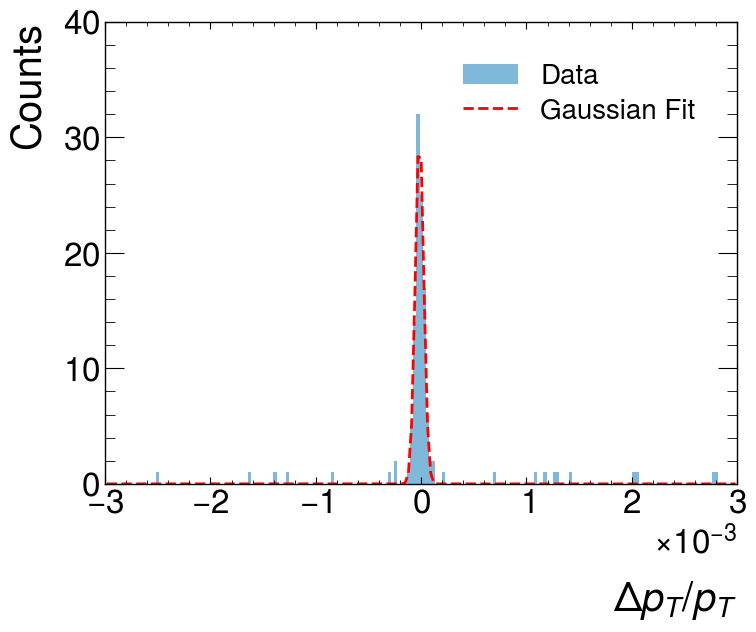

Theta: 45.0 <= theta < 90.0
# of data points (total, pt > 1000): 256 0
Mean from Fit: -5.161554578586369e-06
Sigma from Fit: -2.2997382997352214e-05
------------------------------------


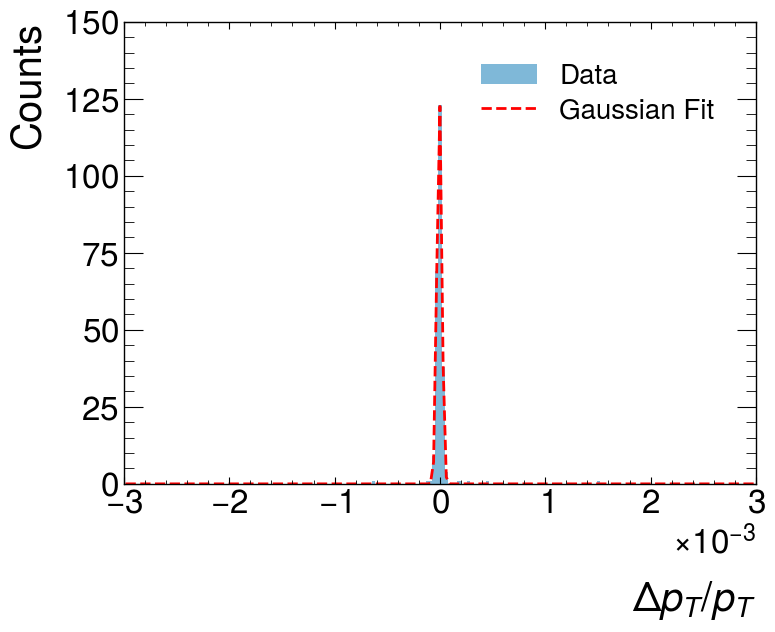

Theta: 90.0 <= theta < 135.0
# of data points (total, pt > 1000): 270 0
Mean from Fit: -3.0914567401958604e-06
Sigma from Fit: -2.357134589515968e-05
------------------------------------


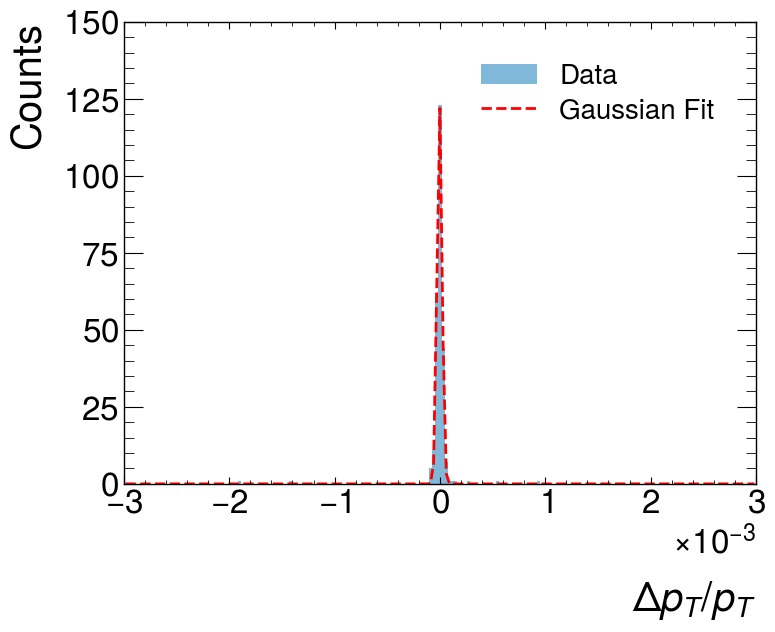

Theta: 135.0 <= theta < 180.0
# of data points (total, pt > 1000): 135 0
Mean from Fit: -2.461140379919145e-07
Sigma from Fit: -3.667012442301336e-05
------------------------------------


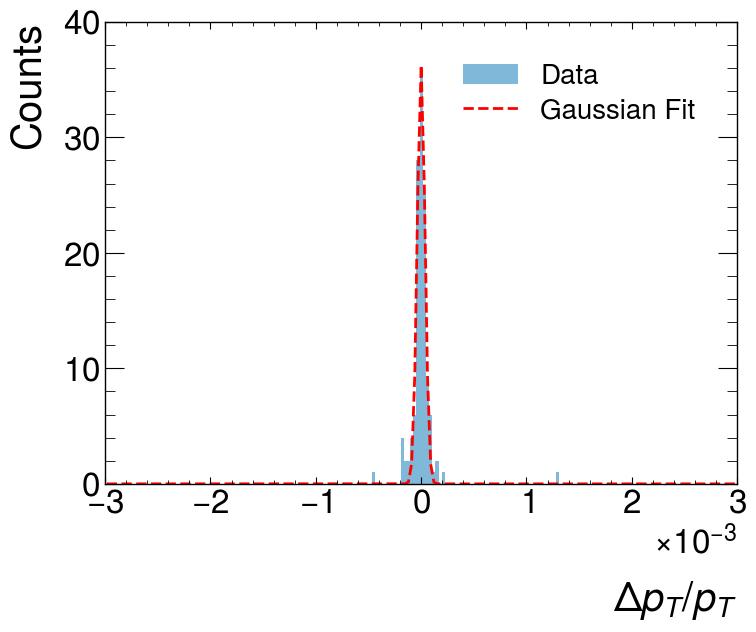

In [25]:
# How many data points? Probably make this same as above for consistency
theta_bins = 4

# Specify which pt range is not working well from: bib_0_50, bib_50_250, bib_250_1000, bib_5TeV
which_data = bib_50_250 

binning = [min(which_data['mcp_mu_pt']), max(which_data['mcp_mu_pt'])]
# which_theta = np.degrees(fold_data(bib_250_1000['LC_track_theta'], bib = True)) # THIS HAS TO BE THE SAME AS which_data, also check for degrees vs radians!!!
which_theta = np.degrees((which_data['LC_track_theta']))

for i in range(theta_bins):
    print(r'Theta:', (180/theta_bins)*i, r'<= theta <', (180/theta_bins)*(i+1))
    # theta_bin = ((180/theta_bins)*i <= which_theta) & (which_theta < (180/theta_bins)*(i+1)) & [np.abs(LC_pt_resolution[0]) < 1 for LC_pt_resolution in fold_data(which_data['LC_pt_res'], bib = True)]
    theta_bin = ((180/theta_bins)*i <= which_theta) & (which_theta < (180/theta_bins)*(i+1)) & [np.abs(LC_pt_resolution[0]) < 1 for LC_pt_resolution in (which_data['LC_pt_res'])]
    # print(which_data['LC_pt_res'][theta_cut])
    count = 0
    for bin in theta_bin:
        if bin[0] == True:
            count +=1
    # print("# of data points (total, pt > 1000):", count, len(ak.flatten(fold_data(which_data['LC_pt_match'], bib = True)[theta_bin[fold_data(which_data['LC_pt_match']>1000, bib = True)]]))) # Not sure how 'count' works but it does so don't worry
    print("# of data points (total, pt > 1000):", count, len(ak.flatten((which_data['LC_pt_match'])[theta_bin[(which_data['LC_pt_match']>1000)]]))) # Not sure how 'count' works but it does so don't worry

    # /pT resolution
    # plotrms_slice(which_data['LC_pt_match'][theta_bin], (which_data['LC_pt_res']*which_data['LC_pt_match'])[theta_bin], x_bins = x_bins_250_1000, bins=pt_bins, title=pt_title, rv = False, sigma5 = False)
    
    # /pT^2 resolution
    plotrms_slice((which_data['LC_pt_match'])[theta_bin], ((which_data['LC_pt_res']/which_data['LC_pt_match']))[theta_bin], x_bins = binning, bins=pt_bins, xlim = None, title=pt_title+r'/$p_T$', rv = False, sigma5 = False)
    # (this is meant to be with fold_data but does not seem to work)
    # plotrms_slice(fold_data(which_data['LC_pt_match'], bib = True)[theta_bin], fold_data((which_data['LC_pt_res']/which_data['LC_pt_match']), bib = True)[theta_bin], x_bins = binning, bins=pt_bins, xlim = None, title=pt_title+r'/$p_T$', rv = False, sigma5 = False)
    
    # d0 resolution
    # plotrms_slice(which_data['LC_pt_match'][theta_bin], which_data['LC_d0'][theta_bin], x_bins = [1000,5000], bins=pt_bins, xlim = None, title=d0_title, rv = False, sigma5 = False)
    # if i == 5:
    #     break